# Multi-class classification based on Softmax and Cross-Entropy using pytorch

## import libraries

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm, tqdm_notebook
import random
import os

In [4]:
from google.colab import drive 
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## load data

In [5]:
directory_data  = './drive/MyDrive/Machine_Learning/'
filename_data   = 'assignment_06_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

x_train = data['x_train']
y_train = data['y_train']

x_test  = data['x_test']
y_test  = data['y_test']

num_data_train  = x_train.shape[0]
num_data_test   = x_test.shape[0]

print('*************************************************')
print('size of x_train :', x_train.shape)
print('size of y_train :', y_train.shape)
print('*************************************************')
print('size of x_test :', x_test.shape)
print('size of y_test :', y_test.shape)
print('*************************************************')
print('number of training image :', x_train.shape[0])
print('height of training image :', x_train.shape[1])
print('width of training image :', x_train.shape[2])
print('*************************************************')
print('number of testing image :', x_test.shape[0])
print('height of testing image :', x_test.shape[1])
print('width of testing image :', x_test.shape[2])
print('*************************************************')

*************************************************
size of x_train : (20000, 32, 32)
size of y_train : (20000,)
*************************************************
size of x_test : (8000, 32, 32)
size of y_test : (8000,)
*************************************************
number of training image : 20000
height of training image : 32
width of training image : 32
*************************************************
number of testing image : 8000
height of testing image : 32
width of testing image : 32
*************************************************


## number of classes

In [6]:
print('*************************************************')
print('number of classes :', len(set(y_train)))
print('*************************************************')

*************************************************
number of classes : 10
*************************************************


## hyper-parameters

In [7]:
device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

number_epoch    = 50
size_minibatch  = 128
learning_rate   = 0.01
weight_decay    = 0.01

## custom data loader for the PyTorch framework

In [8]:
class dataset(Dataset):
    
    def __init__(self, image, label):
        
        self.image  = image
        self.label  = label.astype(np.long)
    
    def __getitem__(self, index):
        
        image   = self.image[index, :, :]
        label   = self.label[index, ]

        image   = torch.FloatTensor(image).unsqueeze(dim=0)
        label   = torch.LongTensor([label])

        return image, label
    
    def __len__(self):
        
        return self.image.shape[0]

    def collate_fn(self, batch):
        images  = list()
        labels  = list()

        for b in batch:
            images.append(b[0])
            labels.append(b[1])

        images  = torch.stack(images, dim=0)
        labels  = torch.stack(labels, dim=0).squeeze()

        return images, labels
        

In [9]:
#https://forensics.tistory.com/29
class EarlyStopping():
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience  = patience
        self.verbose = verbose

    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print(f'Training process is stopped early....')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

## construct datasets and dataloaders for training and testing

In [10]:
dataset_train   = dataset(x_train, y_train)
dataset_test    = dataset(x_test, y_test)

dataloader_train    = torch.utils.data.DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True, collate_fn=dataset_train.collate_fn)
dataloader_test     = torch.utils.data.DataLoader(dataset_test, batch_size=size_minibatch, shuffle=True, drop_last=True, collate_fn=dataset_test.collate_fn)

## shape of the data when using the data loader

In [11]:
image, label    = next(iter(dataloader_train))
print('************************************************************')
print('size of mini-batch of the image:', image.shape)
print('************************************************************')
print('size of mini-batch of the label:', label.shape)
print('************************************************************')

************************************************************
size of mini-batch of the image: torch.Size([128, 1, 32, 32])
************************************************************
size of mini-batch of the label: torch.Size([128])
************************************************************


## class for the neural network 

In [12]:
class ResidualUnit(nn.Module):
    def __init__(self, in_channel, out_channel, stride=1):
        super(ResidualUnit, self).__init__()

        self.main_layer = nn.Sequential (
            nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channel, out_channels=out_channel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channel)
        )

        self.skip_layers = nn.Sequential()
        if stride > 1:
            self.skip_layers = nn.Sequential(
                nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=3, stride=stride, padding=1, bias=False),
                nn.BatchNorm2d(out_channel)
            )

        self.relu = nn.ReLU()

    def forward(self, x):
        Z = self.main_layer(x)
        Z += self.skip_layers(x)
        Z = self.relu(Z)
        return Z

In [13]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.drop_1 = nn.Dropout(p=0.12)
        self.cn_1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=1, padding=1, bias=False)
        self.bn_1 = nn.BatchNorm2d(64)
        self.re_1 = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.resnet = nn.Sequential(
            ResidualUnit(64, 64),
            ResidualUnit(64, 64),
            ResidualUnit(64, 64),

            ResidualUnit(64, 128, stride=2),
            ResidualUnit(128, 128),
            ResidualUnit(128, 128),
            ResidualUnit(128, 128),

            ResidualUnit(128, 256, stride=2),
            ResidualUnit(256, 256),
            ResidualUnit(256, 256),
            ResidualUnit(256, 256),
            ResidualUnit(256, 256),
            ResidualUnit(256, 256),

            ResidualUnit(256, 512, stride=2),
            ResidualUnit(512, 512),
            ResidualUnit(512, 512)
        )
        self.avg = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.drop_2 = nn.Dropout(p=0.1)

        self.classifier_1 = nn.Linear(512, 256)
        self.bn_2 = nn.BatchNorm1d(256)
        self.re_2 = nn.ReLU()

        self.classifier_2 = nn.Linear(256, 128)
        self.bn_3 = nn.BatchNorm1d(128)
        self.re_3 = nn.ReLU()

        self.classifier_3 = nn.Linear(128, 10)

        # nn.init.xavier_uniform_(self.classifier_1.weight)
        # nn.init.xavier_uniform_(self.classifier_2.weight)
        # nn.init.xavier_uniform_(self.classifier_3.weight)

        # nn.init.kaiming_normal_(self.classifier_1.weight)
        # nn.init.kaiming_normal_(self.classifier_2.weight)
        # nn.init.kaiming_normal_(self.classifier_3.weight)

        # nn.init.constant_(self.classifier_1.weight, 0.01)
        # nn.init.constant_(self.classifier_2.weight, 0.01)
        # nn.init.constant_(self.classifier_3.weight, 0.01)

        torch.nn.init.normal_(self.classifier_1.weight)
        torch.nn.init.normal_(self.classifier_2.weight)
        torch.nn.init.normal_(self.classifier_3.weight)


    def forward(self, x):
        Z = self.drop_1(x)
        Z = self.cn_1(Z)
        Z = self.bn_1(Z)
        Z = self.re_1(Z)
        Z = self.maxpool(Z)

        Z = self.resnet(Z)

        Z = self.avg(Z)
        Z = self.flatten(Z)
        # Z = self.drop_2(Z)

        Z = self.classifier_1(Z)
        Z = self.bn_2(Z)
        Z = self.re_2(Z)

        Z = self.classifier_2(Z)
        Z = self.bn_3(Z)
        Z = self.re_3(Z)
        
        Z = self.classifier_3(Z)
        return Z

## build network

In [14]:
classifier  = Classifier()
optimizer   = torch.optim.SGD(classifier.parameters(), lr=learning_rate, weight_decay=weight_decay)
from torchsummary import summary
summary(classifier, (1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1            [-1, 1, 28, 28]               0
            Conv2d-2           [-1, 64, 24, 24]           3,136
       BatchNorm2d-3           [-1, 64, 24, 24]             128
              ReLU-4           [-1, 64, 24, 24]               0
         MaxPool2d-5           [-1, 64, 12, 12]               0
            Conv2d-6           [-1, 64, 12, 12]          36,864
       BatchNorm2d-7           [-1, 64, 12, 12]             128
              ReLU-8           [-1, 64, 12, 12]               0
            Conv2d-9           [-1, 64, 12, 12]          36,864
      BatchNorm2d-10           [-1, 64, 12, 12]             128
             ReLU-11           [-1, 64, 12, 12]               0
     ResidualUnit-12           [-1, 64, 12, 12]               0
           Conv2d-13           [-1, 64, 12, 12]          36,864
      BatchNorm2d-14           [-1, 64,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## print the defined neural network

In [15]:
print(classifier)

Classifier(
  (drop_1): Dropout(p=0.12, inplace=False)
  (cn_1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), bias=False)
  (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (re_1): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (resnet): Sequential(
    (0): ResidualUnit(
      (main_layer): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (skip_layers): Sequential()
      (relu): ReLU()
    )
    (1): ResidualUnit(
      (main_layer): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

## compute the prediction

In [16]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

## compute the loss

In [17]:
def compute_loss(prediction, label):

    criterion   = nn.CrossEntropyLoss()
    loss        = criterion(prediction, label)
    loss_value  = loss.item()

    return loss, loss_value

## compute the accuracy

In [18]:
def compute_accuracy(prediction, label):
    # ================================================================================ 
    # complete the function body
    b_Prediction = torch.argmax(prediction, 1)
    bCorrect = (b_Prediction == label)
    accuracy = bCorrect.float().mean() * 100
    # ================================================================================ 

    return accuracy

## variables for the learning curve

In [19]:
loss_mean_train     = np.zeros(number_epoch)
loss_std_train      = np.zeros(number_epoch)
accuracy_mean_train = np.zeros(number_epoch)
accuracy_std_train  = np.zeros(number_epoch)

loss_mean_test      = np.zeros(number_epoch)
loss_std_test       = np.zeros(number_epoch)
accuracy_mean_test  = np.zeros(number_epoch)
accuracy_std_test   = np.zeros(number_epoch)

## train and test

In [20]:
## For Debugging
classifier  = Classifier().to(device)
optimizer   = torch.optim.SGD(classifier.parameters(), lr=learning_rate, weight_decay=weight_decay)
early_stopping = EarlyStopping(patience=70, verbose=1)

# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm_notebook(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    loss_train_epoch        = []
    accuracy_train_epoch    = []

    classifier.train()

    for index_batch, (image_train, label_train) in enumerate(dataloader_train):

        image_train = image_train.to(device)
        label_train = label_train.to(device)
        
        prediction_train                = compute_prediction(classifier, image_train)
        loss_train, loss_value_train    = compute_loss(prediction_train, label_train)
        accuracy_train                  = compute_accuracy(prediction_train, label_train).to("cpu")
        accuracy_train = accuracy_train.numpy()
        # loss_value_train = loss_value_train.to("cpu")

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        loss_train_epoch.append(loss_value_train)
        accuracy_train_epoch.append(accuracy_train)

    loss_mean_train[i]      = np.mean(loss_train_epoch)
    loss_std_train[i]       = np.std(loss_train_epoch)

    accuracy_mean_train[i]  = np.mean(accuracy_train_epoch)
    accuracy_std_train[i]   = np.std(accuracy_train_epoch)

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    loss_test_epoch        = []
    accuracy_test_epoch    = []

    with torch.no_grad():
        classifier.eval()

    for index_batch, (image_test, label_test) in enumerate(dataloader_test):

        image_test = image_test.to(device)
        label_test = label_test.to(device)
        
        prediction_test             = compute_prediction(classifier, image_test)
        loss_test, loss_value_test  = compute_loss(prediction_test, label_test)
        accuracy_test               = compute_accuracy(prediction_test, label_test).to("cpu")
        accuracy_test = accuracy_test.numpy()

        loss_test_epoch.append(loss_value_test)
        accuracy_test_epoch.append(accuracy_test)

    loss_mean_test[i]      = np.mean(loss_test_epoch)
    loss_std_test[i]       = np.std(loss_test_epoch)

    accuracy_mean_test[i]  = np.mean(accuracy_test)
    accuracy_std_test[i]   = np.std(accuracy_test)

    if i % 5 == 0:
        print(f"epoch : {i}, train acc : {np.mean(accuracy_train_epoch)}, train loss : {np.mean(loss_train_epoch)}")
        print(f"epoch : {i}, test acc : {np.mean(accuracy_test_epoch)}, test loss : {np.mean(loss_test_epoch)}")
        print()

    # if early_stopping.validate(np.mean(loss_test_epoch)):
    #     break



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/50 [00:00<?, ?it/s]

epoch : 0, train acc : 75.33052825927734, train loss : 1.0871864500909278
epoch : 0, test acc : 94.32963562011719, test loss : 0.18320149243358644

epoch : 5, train acc : 99.4090576171875, train loss : 0.02111513587162615
epoch : 5, test acc : 97.50504302978516, test loss : 0.08011597923694118

epoch : 10, train acc : 99.70953369140625, train loss : 0.00971906668602083
epoch : 10, test acc : 98.07207489013672, test loss : 0.07201864217190192

epoch : 15, train acc : 99.89984130859375, train loss : 0.0048612911789230285
epoch : 15, test acc : 98.71471405029297, test loss : 0.04739951512273101

epoch : 20, train acc : 99.8447494506836, train loss : 0.006898073438862458
epoch : 20, test acc : 98.67691802978516, test loss : 0.04375307837260827

epoch : 25, train acc : 99.81470489501953, train loss : 0.006917468950119562
epoch : 25, test acc : 97.70664978027344, test loss : 0.06974364315430003

epoch : 30, train acc : 99.88481903076172, train loss : 0.005073859103364297
epoch : 30, test acc

## plot curve

In [21]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title):

    plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

In [22]:
def print_curve(data, index):
    
    for i in range(len(index)):

        idx = index[i]
        val = data[idx]

        print('index = %2d, value = %12.10f' % (idx, val))

In [23]:
def get_data_last(data, index_start):

    data_last = data[index_start:]

    return data_last

In [24]:
def get_max_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.max()

    return value

In [25]:
def get_min_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.min()

    return value

---

# functions for presenting the results

---

In [26]:
def function_result_01():

    plot_curve_error(loss_mean_train, loss_std_train, 'epoch', 'loss', 'loss (training)')

In [27]:
def function_result_02():

    plot_curve_error(accuracy_mean_train, accuracy_std_train, 'epoch', 'accuracy', 'accuracy (training)')

In [28]:
def function_result_03():
    
    plot_curve_error(loss_mean_test, loss_std_test, 'epoch', 'loss', 'loss (testing)')

In [29]:
def function_result_04():
    
    plot_curve_error(accuracy_mean_test, accuracy_std_test, 'epoch', 'accuracy', 'accuracy (testing)')

In [30]:
def function_result_05():
    
    data_last = get_data_last(loss_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [31]:
def function_result_06():
    
    data_last = get_data_last(accuracy_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [32]:
def function_result_07():
    
    data_last = get_data_last(loss_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [33]:
def function_result_08():
    
    data_last = get_data_last(accuracy_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [34]:
def function_result_09():
    
    value = get_max_last_range(accuracy_mean_train, -10)
    print('best training accuracy = %12.10f' % (value))

In [35]:
def function_result_10():
    
    value = get_max_last_range(accuracy_mean_test, -10)
    print('best testing accuracy = %12.10f' % (value))

---

# RESULTS

---

## # 01. plot the training loss curve (mean, std)

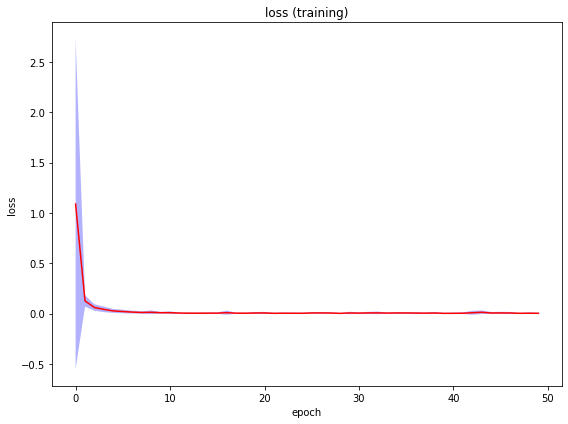

In [36]:
function_result_01()

## # 02. plot the training accuracy curve (mean, std)

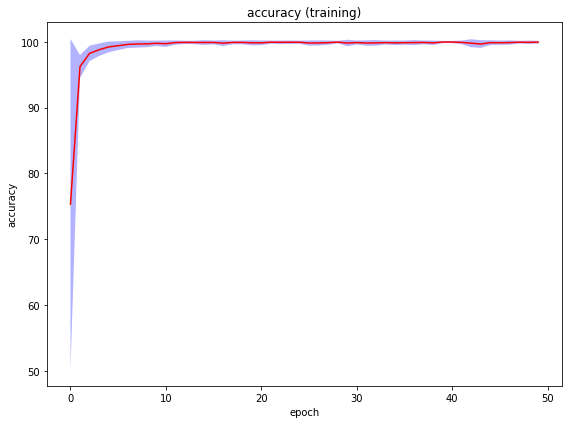

In [37]:
function_result_02()

## # 03. plot the testing loss curve (mean, std)

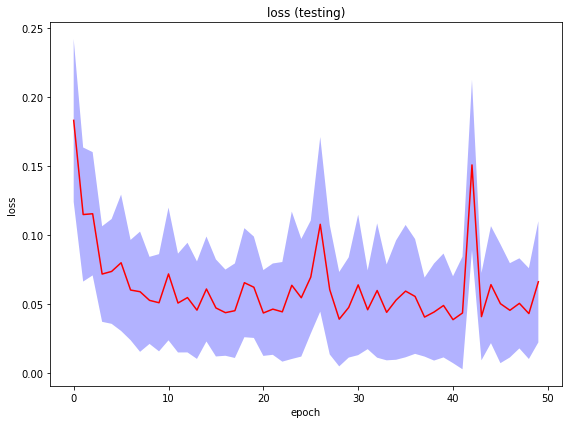

In [38]:
function_result_03()

## # 04. plot the testing accuracy curve (mean, std)

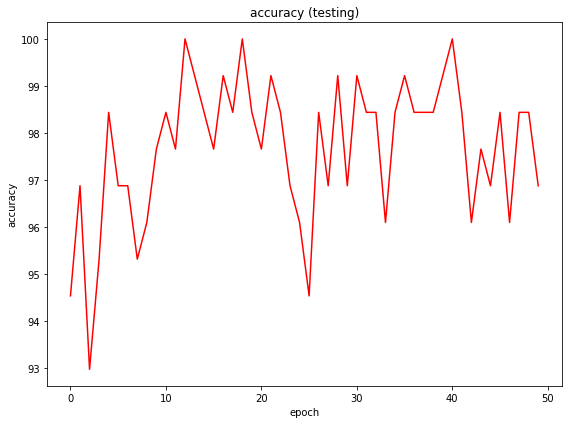

In [39]:
function_result_04()

## # 05. print the training (mean) loss over batches at last 10 epochs

In [40]:
function_result_05()

index =  0, value = 0.0032834779
index =  1, value = 0.0042713669
index =  2, value = 0.0088912680
index =  3, value = 0.0136343252
index =  4, value = 0.0065583303
index =  5, value = 0.0070917508
index =  6, value = 0.0063847185
index =  7, value = 0.0033355559
index =  8, value = 0.0042205462
index =  9, value = 0.0033367026


## # 06. print the training (mean) accuracy over batches at last 10 epochs

In [41]:
function_result_06()

index =  0, value = 99.9599380493
index =  1, value = 99.9098587036
index =  2, value = 99.7796478271
index =  3, value = 99.6594543457
index =  4, value = 99.8647842407
index =  5, value = 99.8597793579
index =  6, value = 99.8798065186
index =  7, value = 99.9399032593
index =  8, value = 99.9198684692
index =  9, value = 99.9399032593


## # 07. print the testing (mean) loss over batches at last 10 epochs

In [42]:
function_result_07()

index =  0, value = 0.0389075413
index =  1, value = 0.0437643338
index =  2, value = 0.1509445142
index =  3, value = 0.0411230060
index =  4, value = 0.0642759264
index =  5, value = 0.0504894438
index =  6, value = 0.0456963370
index =  7, value = 0.0507285784
index =  8, value = 0.0433133442
index =  9, value = 0.0663557889


## # 08. print the testing (mean) accuracy over batches at last 10 epochs

In [43]:
function_result_08()

index =  0, value = 100.0000000000
index =  1, value = 98.4375000000
index =  2, value = 96.0937500000
index =  3, value = 97.6562500000
index =  4, value = 96.8750000000
index =  5, value = 98.4375000000
index =  6, value = 96.0937500000
index =  7, value = 98.4375000000
index =  8, value = 98.4375000000
index =  9, value = 96.8750000000


## # 09. print the best training (mean) accuracy within the last 10 epochs

In [44]:
function_result_09()

best training accuracy = 99.9599380493


## # 10. print the best testing (mean) accuracy within the last 10 epochs

In [45]:
function_result_10()

best testing accuracy = 100.0000000000
